# An introduction to software design (for scientists)

Scientists write terrible code. Arguably, most people write terrible code, but our job is to explore and try new thing, so it makes sense that this involves a lot of nasty code. Think "prototype" algorithms, messy data munging and loooots of absolute file paths - **hero code** written during late-night, caffeine fuelled binges, and requiring a superhero (you) to safely use, repurpose, or even run on a different computer. 

This is a problem. While hero code is part of the creative process - it's inevitable when we want to test a new idea or see if something works - writing ONLY hero code wastes time and causes excessive hair loss by:

1. Being generally hard to debug (as complexity increases)
2. Requiring extensive rewriting every time it is used (in different situations)
3. Including it's author as a dependency - if nobody can use your code without your help then either nobody will use it or you'll be bombarded by pleas for help

## Aims

This tutorial aims to introduce three things:

1. some of the principles of software design and why they matter, with a worked example.

2. basic GIT usage.

3. the python package system.

We assume basic knowledge of python and numpy, although this is not entirely needed to grasp the main ideas being presented.

## A short note on GIT

This does not aim to be a comprehensive introduction to GIT - there are plenty of these [available already](https://medium.com/swlh/an-introduction-to-git-and-github-22ecb4cb1256) - but we do intentionally use git in a basic way so that you can start becoming familiar with it. 

In short, git is essentially a version control system that tracks how code changes over time, and allows changes to be removed (*reverted*), or multiple versions (*forks*) to be created (e.g. for editing by different people) and subsequently merged (*pulled*).

Combined with services like [GitHub](https://github.com/), this provides access to millions of open-source code projects and facilitates collaboration between developers.

----
<center>
<img src="https://hikaruzone.files.wordpress.com/2015/10/in-case-of-fire-1-git-commit-2-git-push-3-leave-building2.png" width="500px">
</center>

---

We won't go into the details of using git (please refer to the internets for that), but we'll use it to copy code and (later) look at some of the funky things it can do in the software engineering context.

To start todays tutorial, we will *clone* (read copy) the tutorial files from GitHub. Start by making your own *fork* of the base repository by clicking the fork button on this page: https://gitlab.hzdr.de/thiele67/intro_to_software_design.


In [1]:
!git clone https://gitlab.hzdr.de/thiele67/intro_to_software_design.git
%cd intro_to_software_design/

Cloning into 'intro_to_software_design'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11
Unpacking objects: 100% (11/11), done.
/content/intro_to_software_design


Looking in the Files browser on the left, you should now see a folder called intro_to_sofware_design. This is the git repository that we have cloned - enter it and you'll see the tutorial files, including the jupyter notebook that contains the main part of this tutorial.

But ... before launching this we need to quicly install *hylite* in this Colab instance. This can take a while, so please give it some time. 

Once it is done, please continue to the next part of this notebook.

In [2]:
!pip install hylite

# clear output (it isn't easy being clean!)
from IPython.display import clear_output
clear_output()

import hylite # check in case there are errors 

## Part One: Hero Code

-------

As already mentioned, hero code is part of the creative process - it's inevitable when we want to test a new idea or see if something works. But writing ONLY hero code wastes time and causes excessive hair loss by:

1. Being generally hard to debug (as complexity increases)
2. Requiring extensive rewriting every time it is used (in different situations)
3. Including it's author as a dependency - if nobody can use your code without your help then either nobody will use it or you'll be bombarded by pleas for help

This last point is important: we all want our work to have impact. Code that runs once can do little more than create a pretty figure; code that can be deployed and run billions of times by many different users can change the world. And if you don't write code that is deployable, then nobody else will - they have better things to do.

----

<center><img src="https://miro.medium.com/max/480/1*VNh2ihTMppouMBHH5zZlzw.jpeg" width="500px"></center>

---

To start this mini-tutorial, I've included a typical example of hero-code. It loads a hyperspectral image dataset, applies a principal component analysis (PCA) to reduce it's dimensionality, and then classifies the result using a k-means classifer. While this could be easily done with existing libraries, I've implemented everything from scratch to serve as an example.

In [3]:
import hylite
from hylite import io
import numpy as np
import matplotlib.pyplot as plt

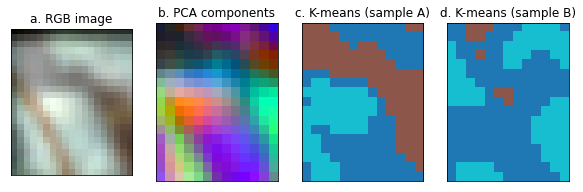

In [8]:
# load awesome dataset
image = io.load('/Users/thiele67/Documents/notebooks/teaching/Hero_to_Zero/sampleA.hdr')
# image = io.load('sampleA.hdr')
fig,ax = plt.subplots(1,4,figsize=(10,4))
image.quick_plot(hylite.RGB, rot=True, ax=ax[0])

# not sure what this does exactly, but it seemed like a good idea at the time
X = image.data[3:-3,3:-3,10:-5].reshape((-1,435))
X = X / 10000.

# performance optimisation hack
X = X[::3, : ]

# PCA
mean = np.mean(X, axis=0)
X = X - mean[None, :]
cov = np.dot(X.T, X) / (X.shape[0] - 1) 
eigval, eigvec = np.linalg.eig(cov)
idx = np.argsort(np.abs(eigval))[::-1]
eigvec = eigvec[:, idx]
eigval = np.abs(eigval[idx])
data = image.data[3:-3,3:-3,10:-5] - mean
out = np.zeros((data.shape[0],data.shape[1],3))
for b in range(0, 3):
    out[..., b] = np.dot(data, eigvec[:, b])
pca = hylite.HyImage(out)
pca.quick_plot((0,1,2), rot=True, vmin=2, vmax=98, tscale=True, ax=ax[1])
fig.show()

# classify
np.random.seed(42)
xcentroid = np.random.randint(0,pca.xdim(),3)
ycentroid = np.random.randint(0,pca.ydim(),3)
centroids = np.vstack([xcentroid,ycentroid]).T
centroids = pca.data[centroids[:,0], centroids[:,1],:]
delta = np.array([np.inf, np.inf, np.inf])
while np.max(delta > 0.0001):
    clss = np.argmin( np.linalg.norm( (pca.data[None,:,:,:] - centroids[:,None,None,:]), axis=-1 ), axis=0 )
    means = np.array([np.mean( pca.data[clss==i, :], axis=0) for i in range(3)])
    delta = np.linalg.norm(centroids - means, axis=1 )
    centroids = means
hylite.HyImage(clss[...,None]).quick_plot(0,cmap='tab10',rot=True, ax=ax[2])

# classify another image (using previously "learned" centroids)
image = io.load('/Users/thiele67/Documents/notebooks/teaching/Hero_to_Zero/sampleB.hdr')
# image = io.load('sampleB.hdr')

data = image.data[3:-3,3:-3,10:-5] - mean
out = np.zeros((data.shape[0],data.shape[1],3))
for b in range(0, 3):
    out[..., b] = np.dot(data, eigvec[:, b])
clss = np.argmin( np.linalg.norm( (out[None,:,:,:] - centroids[:,None,None,:]), axis=-1 ), axis=0 )

hylite.HyImage(clss[...,None]).quick_plot(0,cmap='tab10',rot=True, ax=ax[3])

ax[0].set_title('a. RGB image')
ax[1].set_title('b. PCA components')
ax[2].set_title('c. K-means (sample A)')
ax[3].set_title('d. K-means (sample B)')

fig.show()

#### Exercise

Use the above code to create a set of elbow plots for different numbers of PCA components

## Part two: A better way

As the above exercise should have demonstrated, simple adjustments such as the number of classes or number of PCA dimensions are not easy (and basically require the code to be entirely re-written). Hence, while the code is not wrong (it works!) it is not reusable and basically useless except for the specific task and dataset it was written for.

There are many different (and often conflicting) [design principles](https://www.callicoder.com/software-development-principles/) that can help ensure code is maintainable, durable and reusable. The most important points to keep in mind for this exercise are summarised below.

###### KISS: Keep it simple, stupid
It's very easy to make things far more complex than they need to be. Try and keep software tools focused and as simple as possible.

###### DRY: Don't repeat yourself
Break code into well defined, bit-sized functions rather than repeating (copy + paste is evil!) code. This makes it easier to (1) find and correct bugs, (2) make changes or updates and (3) provides lots of useful components for building new software.

###### Single responsibility principle
Functions should have a single purpose and be organised (into modules) according to their responsibilities

###### Continuous testing
Test always - every block of code should be tested individually during development (in e.g., a notebook environment) and then test functions written to automatically identify issues caused by subsequent changes. 

###### Document everything
Code without documention is unusable. And there are now so many tools for creating and using documentation that there are no excuses either 😉

----------
<center>
<img src="https://preview.redd.it/0jelwo9pgcv21.jpg?width=640&crop=smart&auto=webp&s=afc465891e9cd751e8cb866612cff494c60b7a8a" width="400px">

**Sometimes it is easiest to start from scratch...**
</center>

---------

To demonstrate some of the above principals, lets break our "hero code" example into chunks that fit with our design principles. 


#### Exercise

Define a set of functions (no need to implement them) that breaks the above hero code into chunks that conform especially with the KISS and DRY principles. Also write docstrings for these functions following the [google docstrings](https://gist.github.com/redlotus/3bc387c2591e3e908c9b63b97b11d24e) style. If done consistently (from the start of a project!) these can then easily be converted to a friendly website, such as for [hylite](https://hifexplo.github.io/hylite/hylite.html).

In [ ]:
# write functions here

In [ ]:
# write test code here (more on this later!)


## Part three: Testing and modules

### Testing
While the code above gives us some confidence that our functions are doing what they should, it is best practice to write some python functions that can do this automatically. Then, if you make some cool improvments or changes you can just run these test functions to see if your code still works.

Python provides several *testing frameworks* to help with this, but to start with we'll write some test functions using pytest.



In [ ]:
!pip install pytest
# clear output (it isn't easy being clean!)
from IPython.display import clear_output
clear_output()

While we could probably convert our code the test cells above into pytest functions, this is not generally good practice as it relies on external data. This is the biggest challenge when writing good test code - (1) how do I automatically generate a realistic input for my function (think intput data), and (2) how do I know if the results are correct?

For the case of K-means it is not too hard however - as we can create a synthetic dataset with three subclusters.

In [ ]:
def generate_data(n=3,ndims=10,points_per_class=10):
    """
    Generate a synthetic dataset with n clusters for testing k-means.
    """
    X = []
    for i in range(n):
    X.append( i*3 + np.random.rand(points_per_class,ndims))
    return np.vstack(X)

def test_pca():
    """
    N.B. This test function simply runs code but does not check its output - this
       a "shallow" test.
    """
    X = generate_data(3,10,10)

    loadings, mean = pca_loadings( X, step=1, ndims=3 )
    assert loadings.shape == (10,3), "Error - loadings returned wrong shape (%s)." % loadings.shape

    pca = apply_loadings( X, loadings )
    assert pca.shape == (30,3), "Error - pca returned wrong shape (%s)." % pca.shape

def test_kmeans():
    X = generate_data(3,10,50)
    X=X.reshape( (15,10,10) ) # change shape of inputs to test shape independence
    loadings, mean = pca_loadings( X, step=2, ndims=2 ) # try to ensure test functions test a wide range of parameter configurations
    pca = apply_loadings( X, loadings )
    centroids, clss =  kmeans(pca, 3 )

    # check classification is correct
    clss = clss.ravel()
    assert len(np.unique(clss)) == 3, "Error - kmeans gave incorrect number of classes"
    assert (clss[:50] == clss[0]).all(), "Error - kmeans gave incorrect classification."
    assert (clss[50:100] == clss[50]).all(), "Error - kmeans gave incorrect classification."
    assert (clss[100:-1] == clss[100]).all(), "Error - kmeans gave incorrect classification."
  


In [ ]:
# running tests is as easy as this now!
test_pca()
test_kmeans()
print("All tests passed!")

Now that we have these automatic test functions, we can put them in a python file that accompanies our module. But first - we need a module!


### Modules
Modules (or *packages*) are containers of code that can be easily loaded into a python script using the `import` statement. This makes code much much easier to reuse (rather than e.g., copying our functions into every notebook we want to use them in).


Unfortunately, to create a module we have to move out of the jupyter notebook environment, but (fortunately) the community of geeks on GitHub can provide a template package we can pull from and then modify.


In [ ]:
# download a template python package
!git clone https://github.com/hbergen/minimal-python-package.git

The above will have downloaded a template package for us. If we look into this we will see the key ingredients of a python package:

1. *winterfell*: This directory actually is our python package. **Rename this to whatever you want your call your toolbox** - I chose *samsatool*

2. *winterfell/__init__.py*: This is what makes the directory a package. Code in this file will be called when we import the package. **Copy the functions we declared above into this file, along with the relevant import statements.**


3. *setup.py*: this script explains how python should install this package. Details of this are beyond the scope of this tutorial, but open it and have a look. Among other things, it contains the metadata for our python package (e.g. author, licence, etc.). **In the *packages* entry change 'winterfell' to your package name**

4. Create a new python file called **tests.py** and copy our test functions into this. 

These tests can then be run automatically using:

In [ ]:
!python -m pytest minimal-python-package/tests.py

If our tests all passed, now we can **install** our new python toolbox!

In [ ]:
!pip install ./minimal-python-package

Assuming it installed properly (fingers crossed!) we can now import our fantastic functions and use them without having to see all that nasty code!

In [ ]:
import samsatool
#from importlib import reload  # use this to force reload a module after reinstalling
#reload(samsatool) # (if you made a mistake)
from samsatool import nearest_neighbour, kmeans
from samsatool import apply_loadings, pca_loadings

In [ ]:
# show the help docstrings for our functions
help( pca_loadings ) 

In [ ]:
import hylite
from hylite import io

# apply these to a different image to show how they work
image = io.load('sampleB.hdr')

loadings, mean = pca_loadings(image.data)
pca = apply_loadings(image.data, loadings)
centroids, clss =  kmeans(pca, 3 )

fig,ax = hylite.HyImage(clss[...,None]).quick_plot(0, figsize=(4,4), rot=True)
fig.show()

### Part four: Where next with GIT?

So far we have only used a single git command - *git clone* - for downloading code from e.g., github. While this is by far the most common git operation, it can obviously do far far more.

I would suggest looking at a proper [git tutorial](https://medium.com/swlh/an-introduction-to-git-and-github-22ecb4cb1256) to learn about the basics of creating and updating git repositories using *stage*, *commit*, *push* and *pull*. But GoogleColab really isn't the place to do that as setting up git permissions here be rather messy....

Instead, lets look at some of the more advanced things that a git repository can do, as inspiration to help justify the (potentially steep) learning curve.

- [version control and releases](https://docs.github.com/en/repositories/releasing-projects-on-github/about-releases)
- [automatic testing](https://docs.github.com/en/actions/automating-builds-and-tests/building-and-testing-python)
- [build and host documentation websites](https://docs.github.com/en/pages)

The [hylite](https://github.com/hifexplo/hylite) repository uses all of these - have an explore, especially inside the [.github/workflows](https://github.com/hifexplo/hylite/tree/master/.github/workflows) folder. Also see how [tags](https://github.com/hifexplo/hylite/tags) can be used to create and store different releases.



-----

<center><img src="https://miro.medium.com/max/1400/1*B-OPCn67xfe4POnbiJL0Rw.png" width="400px"></center>

----------

## Part Five: Some conclusions

1. Software is a compromise between functionality and complexity (which detetermines robustness and maintainability). Complexity is often necessary, but basic principles like DRY can help keep it to a minimum.

2. Test, test and then test again. And where possible, write reusable test code - your future self will love you for it (even though it's boring).

3. Document completely. Code without documentation is like a bike without pedals - completely useless.

4. Everyone starts with hero code - that's normal - but generally it pays off to rewrite the good bits properly 🤓


<center>
<img src="https://pics.me.me/brenan-keller-brenankeller-a-qa-engineer-walks-into-a-bar-66974927.png" width="400px">
</center>